In [2]:
from bayes import Bayes         # for Bayes
import numpy as np              # for linspace
import scipy.stats as stats     # for binom, uniform
import matplotlib.pyplot as plt # for plot

%matplotlib inline

# Objectives

- Explain how multi-armed bandit addresses the tradeoff between exploitation and exploration, and the relationship to regret.
- Implement the multi-armed bandit algorithm.

## 1. Creating a CTR "bandit"

Let's define a bandit playing Click-Through Rate ! Each website has a probability of provoking click-throughs or not. Drawing from that bandit would toss a coin with a given CTR (probability) returning 0 (not click) or 1 (click).

In [3]:
class ctr_bandit():
    def __init__(self, prob):
        self.prob = prob
        
    def draw(self):
        A_sample = stats.bernoulli.rvs(self.prob, size=1)
        return(A_sample[0])

## 1.1. Each website as a different bandit

Each versions of a given website A, B, C has a different probability of click. **YOU DON'T KNOW THOSE** (but let's pretend).

In [4]:
ctr_banditA = ctr_bandit(0.25)
ctr_banditB = ctr_bandit(0.60)
ctr_banditC = ctr_bandit(0.40)

In [5]:
print "bandit A: {}".format([ctr_banditA.draw() for i in range(30)])
print "bandit B: {}".format([ctr_banditB.draw() for i in range(30)])
print "bandit C: {}".format([ctr_banditC.draw() for i in range(30)])

bandit A: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
bandit B: [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]
bandit C: [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]


## 1.2. Making a bayesian model of those bandits

As we did this morning, let's create a Bayesian model for each of these bandits.

In [36]:
ctr_omega = np.linspace(0, 1, 101)
ctr_priors = { k:stats.beta.pdf(k, a=1, b=1) for k in ctr_omega }

def ctr_likelihood(data, x):
    # what is the likelihood of drawing data
    # given that CTR is x
    # data = 0 for non-click, 1 for click
    return(stats.binom.pmf(data, 1, x))

bayesA = Bayes(ctr_priors.copy(), ctr_likelihood)
bayesB = Bayes(ctr_priors.copy(), ctr_likelihood)
bayesC = Bayes(ctr_priors.copy(), ctr_likelihood)

Now let's compute the posterior using likelihood and prior. For each of the bayesian models `bayesA`, `bayesB`, `bayesC`, we will update those posterior using draws from `ctr_banditA`, `ctr_banditB`, `ctr_banditC`.

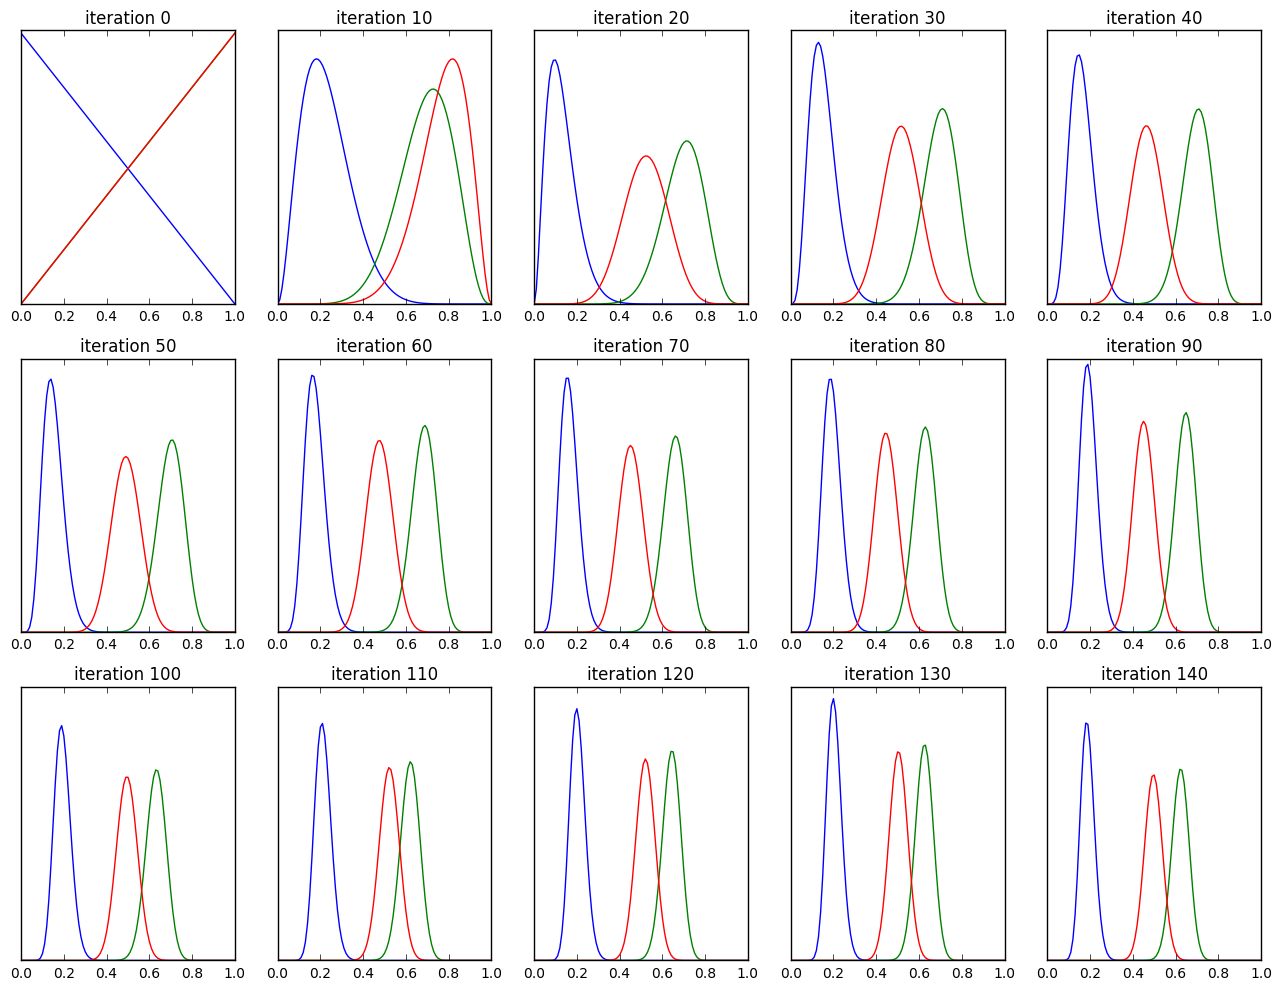

In [37]:
N = 140
N_ratio = 10
N_plots = (N / N_ratio)

fig, axs = plt.subplots(N_plots / 5 + 1, 5, figsize=(16, 4 * (N_plots / 5 + 1)))
axs_array = axs.flatten()

for i in range(N+1):
    # draw a sample from each bandit
    # update each bayesian model using likelihood
    bayesA.update(ctr_banditA.draw())
    bayesB.update(ctr_banditB.draw())
    bayesC.update(ctr_banditC.draw())

    if (i % 10) == 0:
        plot_index = i / N_ratio
        ax = axs.flatten()[plot_index]
        sorted_keys = sorted(ctr_priors.keys())

        sorted_probsA = [bayesA.prior[key] for key in sorted_keys]
        sorted_probsB = [bayesB.prior[key] for key in sorted_keys]
        sorted_probsC = [bayesC.prior[key] for key in sorted_keys]

        ax.plot(sorted_keys, sorted_probsA)
        ax.plot(sorted_keys, sorted_probsB)
        ax.plot(sorted_keys, sorted_probsC)
        ax.get_yaxis().set_ticks([])
        ax.set_title('iteration {}'.format(i))

After some time, keeping A (blue) in the loop seems a waste of energy.

## Question

- Should we discard A at some point ?
- If we did discard A, at which iteration would you do that ?
- Can you identify forces at play here ?

## Question

Can you imagine what would be the impact of discarding a less efficient test (e.g. A in the case above) for the following situations:

- which version of an web ad has a higher click-through rate (CTR)?
- which website is easier to navigate?
- which drug is more effective?

# 2. The "Multi-Armed Bandit" Strategy

Traditional A/B testing would rely on:
- Equal number of observations for A and B.
- Stop the test and use better site.
- Waste time showing users the site that you’ll end up not using.

The Multi-Armed Bandit strategy just consists in:
- Showing user the site you think is the best most of the time.
- Updating belief about true CTR of that site.
- Repeating the process.


## 2.1. General Strategy

Multi-Arm Bandit refers to a mathematical decision problem modeled as **n slot machines (bandits) with unknown expected payout.**

**Goal**: choose order to play the machines so that you maximize expected payout.

No a priori knowledge about the machines.

An algorithm to solve the Multi-Arm Bandit minimizes the regret expressed as:

$$ regret = \Sigma^k_{i=1} (p_{opt} - p_i) = k * p_{opt} - \Sigma^k_{i=1} p_i $$

with:
- $p_{opt}$ : the optimal payout  

- $p_{i}$ : the observed payout

**Regret is the difference of what we won and what we would expect with optimal strategy.**

## 2.2. Implementations

There are several implementations to this general strategy.

### 2.2.1. Epsilon-Greedy algorithm

- With probability $\epsilon$ (usually 10%), choose a random bandit.
- With probability $1-\epsilon$ choose the bandit with the highest expected payout based on past performance.
- Update the performance of the bandit selected.

### 2.2.2. UCB1 Algorithm

Choose a bandit A that maximizes: 

$$p_A + \sqrt{\frac{2 \: log N}{n_A}} $$

With:
- $p_A$ is the expected payout of bandit A
- $n_A$ is the number of times bandit A has been played
- $N$ is the total number of trials so far

This chooses the bandit for whom the Upper Confidence Bound is the highest.

### 2.2.3. Softmax

Choose a bandit by picking randomly, with a probability that is proportional to their payouts. i.e. if A, B, and C are bandits the probability that you pick A is

$$ \frac{e^{CTR_A / \tau}} {e^{CTR_A / \tau} + e^{CTR_B / \tau} + e^{CTR_C / \tau}}$$

With $\tau$ a parameter that controls the 'randomness' of the choice (usually 0.001). 

- if $\tau \to \infty$ the algorithm will choose bandits equally
- if $\tau \to 0$ it will choose the most successful so far.

### 2.2.4. Bayesian bandit

Now that we're bayesian rock stars, let's use bayesian statistics:

- Find probability distribution of payout of each bandit thus far. (how?) 
- For each bandit, sample from distribution.
- Choose bandit for whom the sample has highest expected payout.

## Synthesis

The multi-armed bandit problem maps onto A/B testing naturally
- can easily expand to testing many things simultaneously can tune exploitation versus exploration
- can combine with bayesian methods in a natural way

There are many solutions to the multi-armed bandit problem.
- depend on how you want to make the trade offs
- if payoffs change over time interpretation of bandits regret changes
- will play around with different simulations during the sprint.